In [ ]:
import os
import argparse
import logging

In [ ]:
os.chdir('/home/joe/testbed/Counterfactual-Recurrent-Network')

# get synthetic counterfactual survival data, using cancer sim

In [ ]:
from utils import cancer_simulation

In [ ]:

def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--chemo_coeff", default=2, type=int)
    parser.add_argument("--radio_coeff", default=2, type=int)
    parser.add_argument("--results_dir", default='results')
    parser.add_argument("--model_name", default="crn_test_2")
    parser.add_argument("--b_encoder_hyperparm_tuning", default=False)
    parser.add_argument("--b_decoder_hyperparm_tuning", default=False)
    #return parser.parse_args() 
    return parser.parse_args(args=[]) # to work in jupyter



In [ ]:
args = init_arg()


In [ ]:
pickle_map = cancer_simulation.get_cancer_sim_data(chemo_coeff=args.chemo_coeff, radio_coeff=args.radio_coeff, b_load=False,
                                          b_save=False, model_root=args.results_dir)

In [ ]:
pickle_map.keys()

In [ ]:
pickle_map['training_data'].keys()

In [ ]:
import numpy as np

In [ ]:

num_time_steps = 60  # 6 month followup
num_patients = 50

simulation_params = cancer_simulation.get_confounding_params(num_patients, chemo_coeff=5.0, radio_coeff=5.0)
simulation_params['window_size'] = 15

projection_horizon = 5
treatment_options = np.array(
    [[(1, 0), (0, 0), (0, 1), (0, 0), (0, 0)],
        [(0, 0), (1, 0), (0, 1), (0, 0), (0, 0)]])

outputs = cancer_simulation.simulate(simulation_params, num_time_steps)

#print(outputs['cancer_volume'][:10])
#print(outputs['chemo_probabilities'][:10])
#print(outputs['radio_probabilities'][:10])

# Plot patient

# plot_treatments(63)

print("fin")


In [ ]:
cancer_simulation.plot_treatments(9, outputs)

In [ ]:
cancer_simulation.plot_treatments(3, outputs)

In [ ]:
outputs.keys()

In [ ]:
outputs['sequence_lengths']

## these data are mostly right cnesored, todo tweak the parameters.
# now, model the survival times given the covariates, using DSM

In [ ]:
# what's X?
outputs['patient_types']

In [ ]:
outputs['cancer_volume'].shape

## ... wont work, because covariate vector only has one feature "patient_types". also, for those who are right censored, the cnesorship time is all exactly the same.

# testing SCIGAN

In [ ]:

def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_treatments", default=3, type=int)
    parser.add_argument("--treatment_selection_bias", default=2.0, type=float)
    parser.add_argument("--dosage_selection_bias", default=2.0, type=float)
    parser.add_argument("--save_dataset", default=False)
    parser.add_argument("--validation_fraction", default=0.1, type=float)
    parser.add_argument("--test_fraction", default=0.2, type=float)
    parser.add_argument("--model_name", default="scigan_test")
    parser.add_argument("--verbose", default=False)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--h_dim", default=64, type=int)
    parser.add_argument("--h_inv_eqv_dim", default=64, type=int)
    parser.add_argument("--num_dosage_samples", default=5, type=int)
    parser.add_argument("--alpha", default=1.0, type=float)

    return parser.parse_args(args=[])

In [ ]:
os.chdir('/home/joe/testbed/SCIGAN')

In [ ]:

import argparse
import os
import shutil
import tensorflow as tf

from data_simulation import get_dataset_splits, TCGA_Data
from SCIGAN import SCIGAN_Model
from utils.evaluation_utils import compute_eval_metrics

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



In [ ]:

args = init_arg()

dataset_params = dict()
dataset_params['num_treatments'] = args.num_treatments
dataset_params['treatment_selection_bias'] = args.treatment_selection_bias
dataset_params['dosage_selection_bias'] = args.dosage_selection_bias
dataset_params['save_dataset'] = args.save_dataset
dataset_params['validation_fraction'] = args.validation_fraction
dataset_params['test_fraction'] = args.test_fraction


In [ ]:

data_class = TCGA_Data(dataset_params)
dataset = data_class.dataset
dataset_train, dataset_val, dataset_test = get_dataset_splits(dataset)


# DSM, exposing some learned representation

In [128]:
import os

In [129]:
os.chdir('/home/joe/testbed/DeepSurvivalMachines/')

In [130]:
from dsm import datasets
x, t, e = datasets.load_dataset('PBC', sequential = True)

In [133]:
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()

In [134]:
horizons

[0.25, 0.5, 0.75]

In [135]:
n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'hidden': [50, 100],
              'layers': [3, 2, 1],
              'typ': ['LSTM', 'GRU', 'RNN'],
             }
params = ParameterGrid(param_grid)

In [ ]:
from dsm import DeepRecurrentSurvivalMachines

In [ ]:
models = []
for param in params:
    #model = DeepRecurrentSurvivalMachines(k = param['k'],
    #                             distribution = param['distribution'],
    #                             hidden = param['hidden'], 
    #                             typ = param['typ'],
    #                             layers = param['layers'])
    ## The fit method is called to train the model
    #model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])
    #models.append([[model.compute_nll(x_val, t_val, e_val), model]])
    continue

#best_model = min(models)
#model = best_model[0][1]

In [ ]:
param['layers'] = 3
param['typ'] = 'LSTM'
param

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
x_train[0].shape

# now, try it on the mimic data

In [ ]:
os.chdir('../mimic_understander')

In [ ]:
import pandas as pd

In [ ]:
static_vars = pd.read_csv('./data/interim/static_vars.csv')

In [ ]:
dynamic_vars = pd.read_csv('./data/interim/dynamic_vars.csv')

In [ ]:
outcome_vars = pd.read_csv('./data/interim/outcome_vars.csv')

In [ ]:
input_vars = pd.read_csv('./data/interim/input_vars.csv')

In [ ]:
static_vars.shape

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()


In [ ]:
id_vars = ['subject_id','hadm_id','stay_id']

In [ ]:
dynamic = dynamic_vars.head(1000).set_index(id_vars).values

In [ ]:
dynamic_umap = reducer.fit_transform(dynamic)

In [ ]:
import seaborn as sns

In [ ]:
dynamic_umap.shape

In [ ]:
sns.scatterplot(dynamic_umap[:,0], dynamic_umap[:,1])

In [ ]:
outcomes_matched = pd.merge(dynamic_vars.head(1000), outcome_vars, how='inner', on=id_vars)[['los', 'mort_icu','hospital_expire_flag']]

In [ ]:
outcomes_matched

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(
    dynamic_umap[:,0], dynamic_umap[:,1],
    c=[sns.color_palette()[x] for x in outcomes_matched['mort_icu']])

## joining it with dsm

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
#model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
dynamic_vars.head()

In [ ]:
outcome_vars.head()

In [ ]:
id_vars = ['subject_id','hadm_id','stay_id']

In [ ]:
dynamic_outcome_matched = pd.merge(dynamic_vars.head(10000), outcome_vars, on=id_vars)

In [ ]:
dynamic_outcome_matched.head(10000)

In [ ]:
feat_names = list(dynamic_vars.set_index(id_vars).columns)

In [ ]:
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
x_af_train = []
t_af_train = []
e_af_train = []

for name, group in dynamic_outcome_matched.groupby(id_vars):
    if(len(group) > 1):
        x_af_train.append(group[feat_names].values)
        t_af_train.append(group['los'].values)
        e_af_train.append(group['hospital_expire_flag'].values)

x_af_train = np.array(x_af_train)
t_af_train = np.array(t_af_train)
e_af_train = np.array(e_af_train)

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
model_fitted, embedding = model.fit(x_af_train, t_af_train, e_af_train, iters = 3, learning_rate = param['learning_rate'])

In [ ]:
model_fitted, embedding = model.fit(x_train, t_train, e_train, iters = 3, learning_rate = param['learning_rate'])

In [ ]:
len(x_af_train)

In [ ]:
(x_train, t_train, e_train,
            x_val, t_val, e_val) = model_fitted._prepocess_training_data(x_af_train, t_af_train, e_af_train, vsize=0.2, val_data=None, random_state = 3)

In [ ]:
x_train.view

In [ ]:
model_fitted.torch_model.embedding(x_train)

In [ ]:
model_fitted

# replicating AC TPC with torhc and reasonable libraries

## first, the data

In [387]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
os.chdir('/home/joe/testbed/AC_TPC')

In [2]:
import numpy as np

In [3]:
data = np.load('./data/sample/data.npz')

In [4]:
data_x = data['data_x']
data_y = data['data_y']
y_type = data['y_type']

In [399]:
import utils

In [392]:
utils.foo(5)

48

In [5]:
data_x.shape

(1346, 23, 35)

In [6]:
import torch
import tqdm

In [7]:
data_y.shape

(1346, 23, 3)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
bs = 128 # batch size

In [10]:
torch.cuda.is_available()

True

In [11]:
n_iter = 30

## next, the network components

In [171]:
bs = 128 # batch size
nbatches = int(x_train.shape[0]/bs)+1

In [394]:
x_train, y_train, x_val, y_val = utils.prepocess_training_data_chirag(data_x, data_y, vsize=0.25, random_state=563)

In [173]:
y_train_bozo = (x_train[:,:,0:3] > 55) * 1.0
y_train_bozo[:,:,0] = 1.0
#y_train_bozo

In [174]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [175]:
yb.shape

torch.Size([114, 23, 3])

In [178]:
xb.shape

torch.Size([114, 23, 35])

In [363]:

tf = temp_layer_f()
tg = temp_layer_g()

run_pretrain_loop(x_train, y_train)

100%|██████████| 50/50 [00:09<00:00,  5.23it/s, loss = 0.806, auc = 0.74, val_auc = 0.72]


In [362]:
bb
th = temp_layer_h_gumbo(K=1)

In [407]:
K = 1

In [408]:
utils.training_loop_iter_K(K,x_train, y_train, x_val, y_val, bs)

100%|██████████| 50/50 [00:21<00:00,  2.32it/s, loss = 1.626, auc = 0.75, val_auc = 0.72, auc_squeezed = 0.60, val_auc_squeezed = 0.61]


,loss,auc,val_auc,auc_squeezed,val_auc_squeezed
0,1.6330065727233887,0.727581,0.701168,0.599939,0.599789
1,1.634314775466919,0.71005,0.705025,0.599864,0.61184
2,1.6313326358795166,0.728975,0.71241,0.59345,0.600211
3,1.6305017471313477,0.74101,0.708833,0.590979,0.60022
4,1.6281566619873047,0.741153,0.714164,0.612804,0.601752
5,1.631248950958252,0.7246,0.707081,0.597845,0.607019
6,1.6317070722579956,0.746307,0.713162,0.589938,0.602214
7,1.6329996585845947,0.721918,0.71287,0.590538,0.607203
8,1.6311568021774292,0.737879,0.704686,0.596804,0.607
9,1.6307249069213867,0.733908,0.70601,0.5961,0.605573


In [299]:
import seaborn as sns

<AxesSubplot:xlabel='epoch', ylabel='auc_squeezed'>

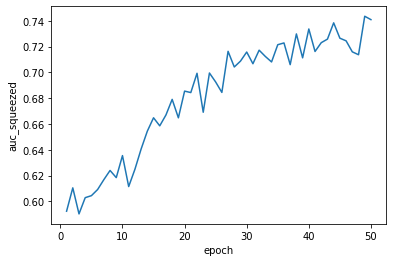

In [361]:
sns.lineplot(data=metrics_record, x='epoch', y='auc_squeezed')

<AxesSubplot:xlabel='epoch', ylabel='auc_squeezed'>

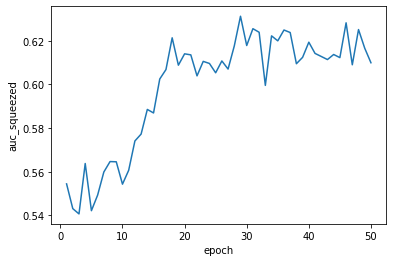

In [365]:
sns.lineplot(data=metrics_record, x='epoch', y='auc_squeezed')

In [278]:
metrics_record_K = training_loop_iter_K(K=16)

100%|██████████| 50/50 [00:20<00:00,  2.48it/s, loss = 1.628, auc = 0.76, val_auc = 0.72, auc_squeezed = 0.61, val_auc_squeezed = 0.62]


In [279]:
metrics_record_K.iloc[-1]

loss                1.6276068687438965
auc                           0.759011
val_auc                       0.710204
auc_squeezed                  0.613464
val_auc_squeezed              0.613353
Name: 49, dtype: object

In [280]:
metrics_record_K = training_loop_iter_K(K=2)

100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss = 1.629, auc = 0.75, val_auc = 0.72, auc_squeezed = 0.60, val_auc_squeezed = 0.62]
